In [1]:
import pandas as pd

import upsetplot
from upsetplot import UpSet

import sys
import os

# silence warnings
import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from tesorai_search import data_parsing_utils

/Users/mburq/miniconda3/envs/tesorai/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
! gsutil -m rsync -r gs://tesorai-data/nature_methods_submission/for_pride ../data/benchmark_results



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Building synchronization state...
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Starting synchronization...
If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.



In [13]:
_DATA_DIR = "../data/benchmark_results/"
benchmark = "bassani_sternberg"
# benchmark = "bekker_jensen"
# benchmark = "williams/1_cells"
# benchmark = "williams/3_cells"
# benchmark = "williams/10_cells"
# benchmark = "williams/50_cells"
# benchmark = "nowatzky"
# benchmark = "carr2019"

benchmark_results = {
    "MaxQuant": set(
        data_parsing_utils.get_maxquant_peptides(
            # _DATA_DIR + f"{benchmark}/maxquant/peptides.txt" # For Nowatzky
            _DATA_DIR
            + f"{benchmark}/maxquant/msms.txt"
        )
    ),
    "Tesorai": set(
        data_parsing_utils.get_tesorai_peptides(
            _DATA_DIR + f"{benchmark}/tesorai/pep_fdr.csv"
        )
    ),
    "FragPipe": set(
        data_parsing_utils.get_fragpipe_peptides(
            _DATA_DIR + f"{benchmark}/fragpipe/peptides.tsv"
        )
    ),
    "PEAKS": set(
        data_parsing_utils.get_peaks_peptides(
            _DATA_DIR + f"{benchmark}/peaks/peptides.csv"
        )
    ),
    "Proteome Discoverer": set(
        data_parsing_utils.get_pd_peptides(
            _DATA_DIR + f"{benchmark}/proteome_discoverer/peptides.xlsx"
        )
    ),
    "Prosit": set(
        data_parsing_utils.get_prosit_peptides(
            _DATA_DIR + f"{benchmark}/prosit/prosit_target.peptides"
        )
    ),
}

Found 22166 peptides by maxquant from 182392 unique rows
Found 47393 peptides by TS
Found 39410 peptides by fragpipe from 39410 unique rows
Found 44396 peptides by PEAKS from 49774 unique rows
Found 35882 peptides by PD from 37941 unique rows
Found 37416 by Prosit from 39478 total ids rows


<Figure size 1000x600 with 0 Axes>

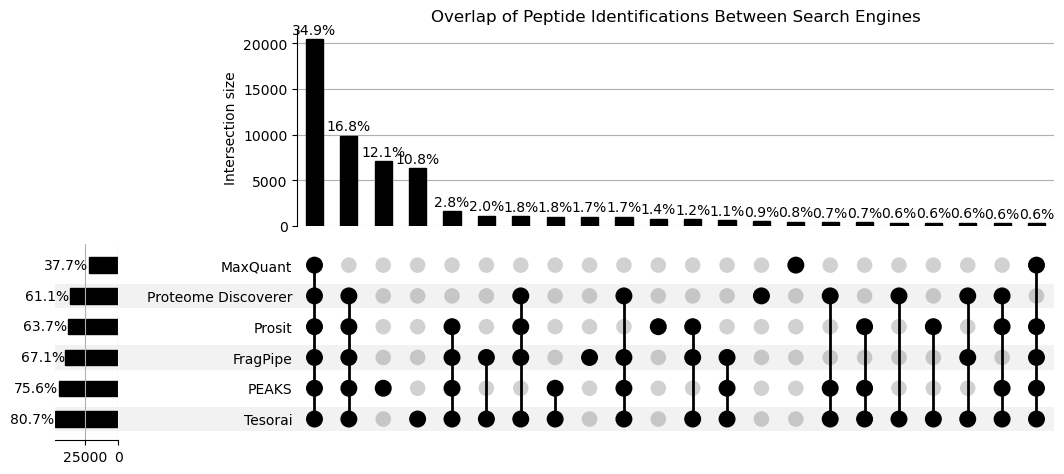

22166
47393
39410
44396
35882
37416
58739


In [14]:
from_contents = upsetplot.from_contents(benchmark_results)

# Create and customize the plot
fig = plt.figure(figsize=(10, 6))
upset = UpSet(
    from_contents,
    sort_by="cardinality",
    show_percentages=True,
    min_subset_size=300,
)
upset.plot()
plt.title("Overlap of Peptide Identifications Between Search Engines")
plt.show()

# print number of peptides identified by each search engine and in the union
for search_engine, peptides in benchmark_results.items():
    print(f"{len(peptides)}")
print(f"{len(set.union(*benchmark_results.values()))}")

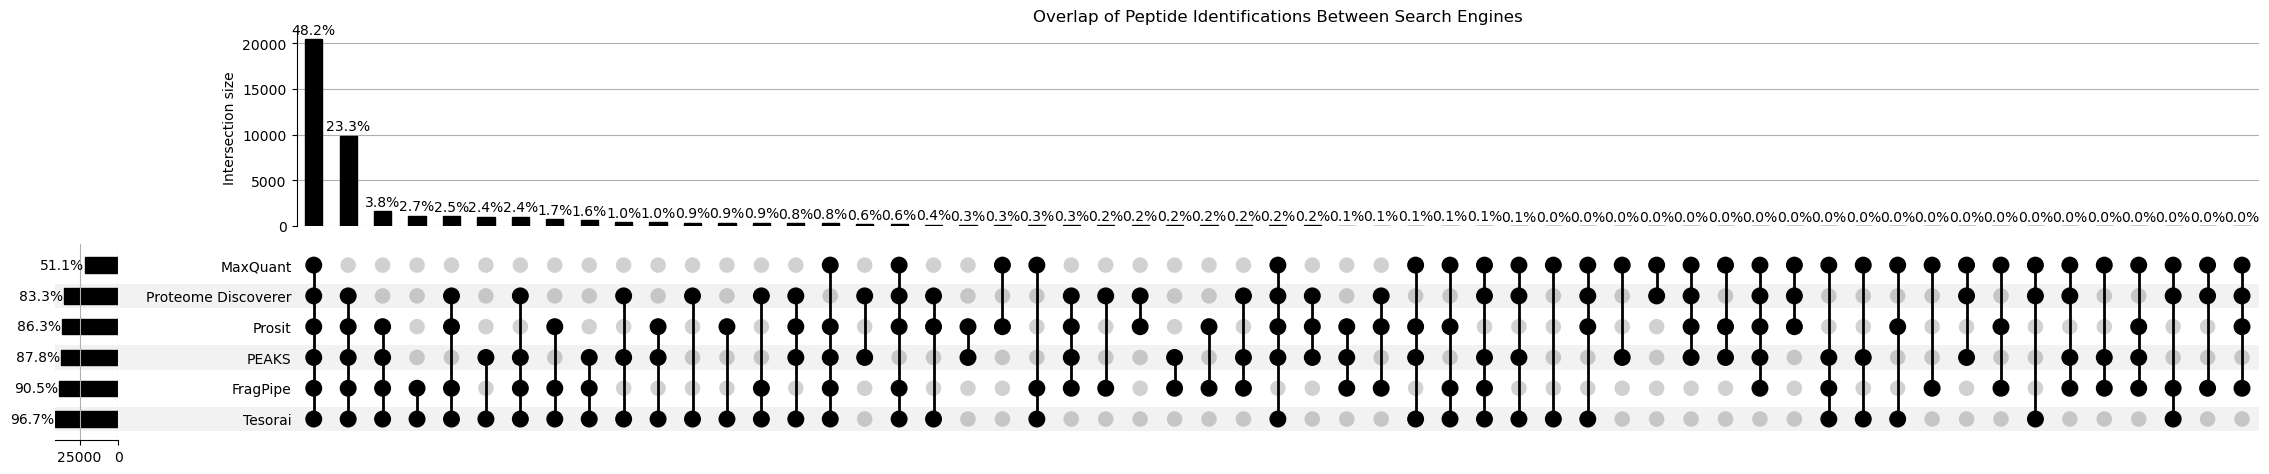

In [15]:
benchmark_results_robust = {}

for search_engine, peptides in benchmark_results.items():
    union_others = set()
    for other_engine, other_peptides in benchmark_results.items():
        if other_engine != search_engine:
            union_others.update(other_peptides)
    # Intersect with the union of all other search engines' peptides
    benchmark_results_robust[search_engine] = peptides.intersection(union_others)

from_contents = upsetplot.from_contents(benchmark_results_robust)

# Create upset plot after removing all entries that are unique to only one search engine
upset = UpSet(
    from_contents,
    sort_by="cardinality",
    show_percentages=True,
    # min_subset_size=300,
)
upset.plot()
plt.title("Overlap of Peptide Identifications Between Search Engines")
plt.show()

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import collections

In [17]:
# Peptides found by at least 3 search engines
all_peptides = set.union(*benchmark_results.values())
peptide_map = collections.defaultdict(int)
for search_engine, peptides in benchmark_results.items():
    for peptide in peptides:
        peptide_map[peptide] += 1

shared_peptides_2 = {peptide for peptide, count in peptide_map.items() if count >= 2}
shared_peptides_3 = {peptide for peptide, count in peptide_map.items() if count >= 3}

Text(-0.1, 1.1, 'E.')

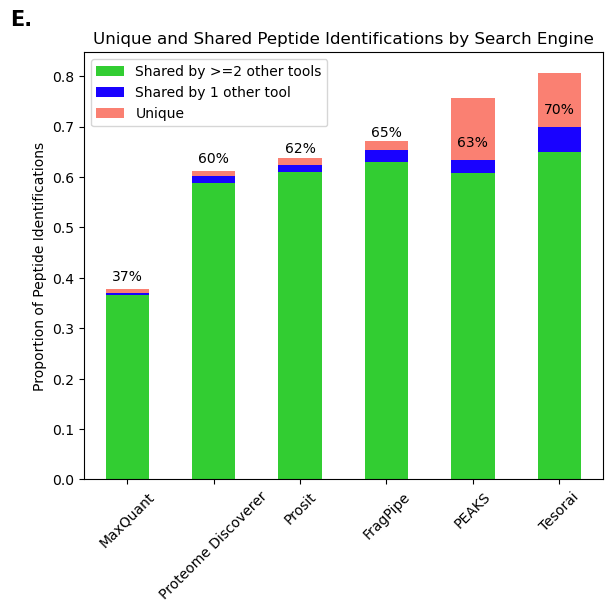

In [ ]:
# Peptides found by at least two search engines
robust_peptides_nomqfp = set.union(
    *[
        peptides
        for search_engine, peptides in benchmark_results_robust.items()
        if search_engine not in ["MaxQuant", "FragPipe"]
    ]
)
robust_peptides_notesorai = set.union(
    *[
        peptides
        for search_engine, peptides in benchmark_results_robust.items()
        if search_engine != "Tesorai"
    ]
)

benchmark_results_unique = {}
total = len(all_peptides)
for search_engine, peptides in benchmark_results.items():
    unique_peptides = len(peptides.difference(shared_peptides_2))
    shared_peptides = len(peptides.intersection(shared_peptides_2))
    shared_peptides_3_n = len(peptides.intersection(shared_peptides_3))
    benchmark_results_unique[search_engine] = (
        shared_peptides_3_n / total,
        (shared_peptides - shared_peptides_3_n) / total,
        unique_peptides / total,
    )

# For Tesorai, exclude MQ and FP from the confirmation set
peptides = benchmark_results["Tesorai"]
unique_peptides = len(peptides.difference(robust_peptides_nomqfp))
shared_peptides = len(peptides.intersection(robust_peptides_nomqfp))
shared_peptides_3_n, _, _ = benchmark_results_unique["Tesorai"]
benchmark_results_unique["Tesorai"] = (
    shared_peptides_3_n,
    shared_peptides / total - shared_peptides_3_n,
    unique_peptides / total,
)

# For FragPipe, exclude Tesorai
peptides = benchmark_results["FragPipe"]
unique_peptides = len(peptides.difference(robust_peptides_notesorai))
shared_peptides = len(peptides.intersection(robust_peptides_notesorai))
shared_peptides_3_n, _, _ = benchmark_results_unique["FragPipe"]
benchmark_results_unique["FragPipe"] = (
    shared_peptides_3_n,
    shared_peptides / total - shared_peptides_3_n,
    unique_peptides / total,
)

results_bar_plot = pd.DataFrame(benchmark_results_unique).T
results_bar_plot["total"] = results_bar_plot.sum(axis=1)
results_bar_plot = results_bar_plot.sort_values(by="total", ascending=True)
results_bar_plot.columns = [
    "Shared by >=2 other tools",
    "Shared by 1 other tool",
    "Unique",
    "Total",
]
results_bar_plot[
    ["Shared by >=2 other tools", "Shared by 1 other tool", "Unique"]
].plot(
    kind="bar", stacked=True, figsize=(6, 6), color=["limegreen", "#1902ff", "salmon"]
)
plt.xticks(rotation=45)
# Add total percents to each bar
for i, row in enumerate(results_bar_plot.iterrows()):
    num_shared = row[1]["Total"] - row[1]["Unique"]
    plt.text(i, num_shared + 0.02, f"{100*num_shared:.0f}%", ha="center", va="bottom")


plt.ylabel("Proportion of Peptide Identifications")
plt.title("Unique and Shared Peptide Identifications by Search Engine")

plt.tight_layout()
plt.text(
    -0.1,
    1.1,
    "E.",
    transform=plt.gca().transAxes,
    fontsize=15,
    fontweight="bold",
    va="top",
    ha="right",
)